In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Signal detection theory

Neural responses are noisy: when a stimulus is presented in many trials, both the occurence in time of the spikes and the total number of spikes in a trial will vary. In these situations we can use signal detection theory to better understand how an observer is responding in the face of this uncertainty. 

In this notebook we will start from an experiment performed by Britten et al in 1992 in area MT of the monkey. As stimuli they used sets of moving dots which could go in one of two directions. One of the moving directions was choosen as to maximaze the neural response of a neuron from which they were recording (i.e. it was the prefered movement direction for that neuron). The opposite moving direction was choosen for the second stimulus. A crucial manipulation was the motion coherence of the stimulus, where 100% motion coherence indicates that all the dots were moving in the same direction, and 0 % motion coherence indicates that all dots are moving in a random direction. The task of the monkey was to indicate the movement direction of the stimulus.

In order to illustrate the methods of signal detection theory we will simulate a motion selective MT cell. This cell has a prefered motion direction $\theta_{pref}$, a baseline firing rate $K$, and its response characteristics are furhter described by a tuning width $\sigma$ and a baseline firing rate $K$. An additional parameter *c* is also included to simulate the effect of motion coherence on the tuning curve.

$$r(\theta) = c r_{max}\exp{(\frac{(\theta - \theta_{pref})^2}{2\sigma^2})} + K$$

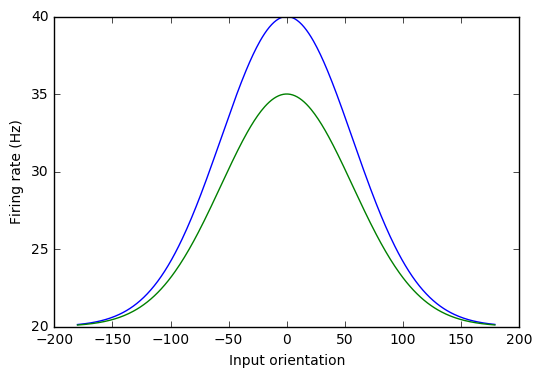

In [25]:
# Definition of the neural tuning curve
def r(theta, theta_p = 0, c = 1.0, r_max = 20, K = 20, sigma = 40):
    A = c*r_max
    return A*np.exp(-0.5*(theta-theta_p)**2/(2*sigma**2)) + K

# Plot of the tuning curve for two different coherence values
theta = np.arange(-180,180)
plt.plot(theta,r(theta,c=1.0))
plt.plot(theta,r(theta,c=0.75))
plt.xlabel('Input orientation')
plt.ylabel('Firing rate (Hz)')



## 1. Response distributions
The tuning curves give an estimate of the average firing rate that could be observed over many presentations of the same stimulus. The actual firing rate, or number of spikes, in a particular trial will vary. If we assume that the neuron can be described by a Poisson process, then we can use the predicted firing rate for a given input orientation to generate actual spike counts for different trials. 

In the following code we use the predicted firing rate for the prefered motion direction and an orthogonal direction to simulate 200 trials with a duration of 1 second. This gives us an idea of the number of spikes we can expect when the prefered stimulus (S+) is presented, compared to when an orthogonal stimulus is presented.

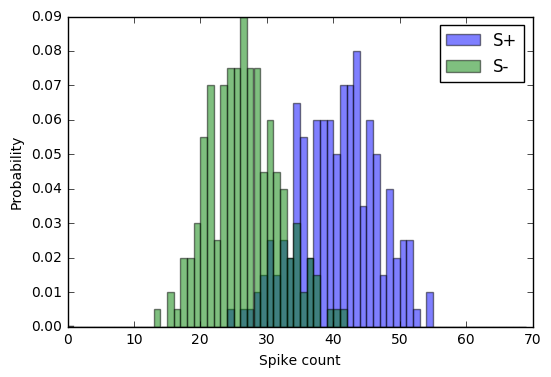

In [26]:
# Simulate spike counts for prefered and orthogonal stimulus presentations
n_trials = 200
r_plus = np.random.poisson(r(0, c=1.0), n_trials)
r_min  = np.random.poisson(r(90,c=1.0), n_trials)  

# Plot the response distributions
bins = np.arange(0,70)
plt.hist(r_plus,bins, alpha = 0.5,normed=True)
plt.hist(r_min,bins, alpha = 0.5, normed=True)
plt.legend(['S+','S-'])
plt.xlabel('Spike count')
plt.ylabel('Probability')

## 2. Receiver operating characteristic
The response distributions illustrate the problem that an observer is confronted with when he or she only has information available from this single neuron. If the only goal is to maximize the number of correct detections of the S+ stimulus, a naive strategy would be to simply respond that this stimulus was presented in every trial. In practice, this would be implemented by setting a response criterion equal to zero, and respond everytime the neuron fires. However, by looking at the distributions we see that this will come at the cost of also making a lot of false alarms (i.e., responding that the S+ stimulus was presented when in fact the S- stimulus was presented). This can be avoided by choosing a sufficiently high response criterion. Here too a problem can occur if the response criterion is set too high. In that case, we will avoid making many false alarms but at the cost of a very small hit rate (i.e. detecting the S+ stimulus when it was presented).

This shows shows how making an error (i.e. reporting that the S+ stimulus was presented, when in fact it was not) and making a correct response are closely related to each other. The actual criterion that is used will depend on the observer and can depend on different factors (e.g. motivation, consequences of making a mistake). If we know the response distributions, then it is possible to produce an estimate of the maximal achievable performance for the observer using the following procedure:

* Choose a particular criterion value

* Using the response distributions, calculate the proportion of false alarms and the hit rates:
$$FA = P(r > z | S_-)$$
$$HIT = P(r > z | S_+)$$

* Plot the hit rate against the false alarm rate

* Do this for different criterion values

* Calculate the area under the resulting curve

Area under the curve: 0.94475


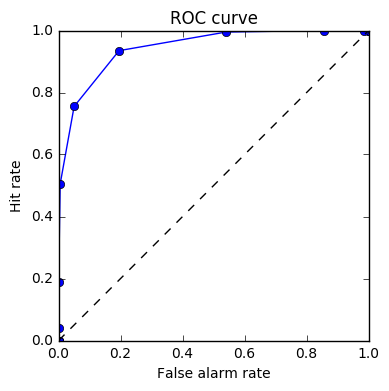

In [31]:
z_values = np.arange(0,100,5)
alpha_z  = np.zeros(len(z_values))
beta_z   = np.zeros(len(z_values))

for i in range(len(z_values)):
    alpha_z[i] = float(np.sum(r_min>z_values[i]))/n_trials
    beta_z[i]  = float(np.sum(r_plus>z_values[i]))/n_trials

auc = np.trapz(beta_z[::-1], x = alpha_z[::-1])

# Plot ROC curve and calculate area under the curve
plt.plot(alpha_z, beta_z,'o-')
plt.plot([0,1],[0,1],'--k')
plt.axis('scaled')
plt.xlabel('False alarm rate')
plt.ylabel('Hit rate')
plt.title('ROC curve')

print("Area under the curve: " + str(auc))

## 3. Neurometric curves
Now that we have a procedure to predict the maximum attainable performance, we can simulate neural responses for different coherence values and calculate the area under the curve for each value. In the case where the response distributions arise from neural histograms, this procedure gives an estimate of the performance that can be achieved in a task when the observer is looking at the firing rate of this particular neuron



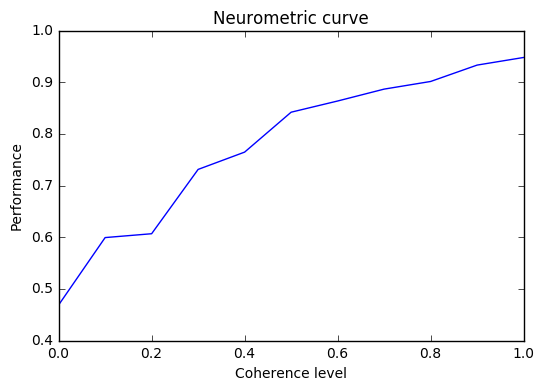

In [32]:
# Calculate area under the curve for different coherence levels
c_values = np.arange(0,1.1,0.1)
auc_performance =np.zeros(len(c_values))

for i in range(len(c_values)):
    r_plus = np.random.poisson(r(0, c=c_values[i]), n_trials)
    r_min  = np.random.poisson(r(90,c=c_values[i]), n_trials)  
    
    alpha_z  = np.zeros(len(z_values))
    beta_z   = np.zeros(len(z_values))
    for j in range(len(z_values)):
        alpha_z[j] = float(np.sum(r_min>z_values[j]))/n_trials
        beta_z[j]  = float(np.sum(r_plus>z_values[j]))/n_trials

    auc_performance[i] = np.trapz(beta_z[::-1], x = alpha_z[::-1])

# Plot the resulting neurometric curve
plt.plot(c_values, auc_performance)
plt.xlabel('Coherence level')
plt.ylabel('Performance')
plt.title('Neurometric curve')

## 4. Simulating response strategies
In addition to calculting the maximal obtainable performance, we can simulate a specific response strategy. One possibility, which was also employed by Britten et al, is to assume that on any given trial, the outcome is obtained by comparing the response of a neuron tuned to the prefered direction with response from an anti-neuron. This is a hypothetical neuron for which the response distribution is determined by the response distribution to the S- stimulus. The response of each neuron is compared and if the response of the prefered stimulus neuron is greater than the response of the hypothetical anti-neuron, the S+ stimulus is selected as a response.

An alternative procedure is that only a single stimulus is presented each trial and the observer sets a criterion. A straightforward response criterion is the midpoint between the mean of the two response distributions. If the response that is observed exceeds the criterion, then the S+ is choosen.


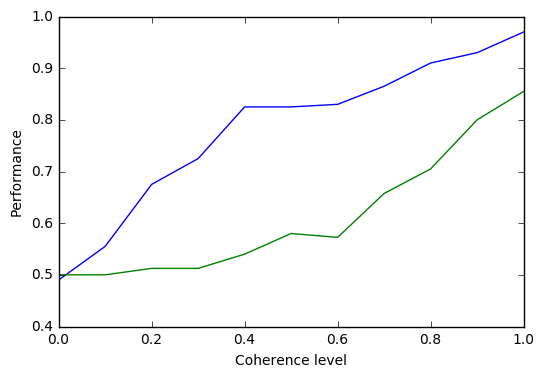

In [34]:
c_values = np.arange(0,1.1,0.1)
fc_performance =np.zeros(len(c_values))
det_performance = np.zeros(len(c_values))
for i in range(len(c_values)):
    r_plus = np.random.poisson(r(0, c=c_values[i]), n_trials)
    r_min  = np.random.poisson(r(90,c=c_values[i]), n_trials)  
    
    #m_det  = (r(0, c=c_values[i])+r(90,c=c_values[i]))/2.0

    fc_performance[i] = np.sum(r_plus>r_min)/float(n_trials)
    det_performance[i] = (np.sum(r_plus>35) + np.sum(r_min<35))/(2.0*n_trials)
    
plt.plot(c_values, fc_performance)
plt.plot(c_values, det_performance)
plt.xlabel('Coherence level')
plt.ylabel('Performance')

Finally, we compare the two strategies with the performance predicted by the ROC curve. Note that the performance predicted by the threshold method is significantly lower than that predicted by the 2AFC method. This is in part because the criterion that was used is independent from the motion coherence levels.

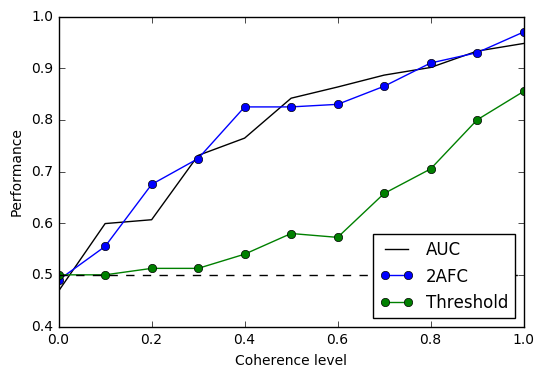

In [35]:
plt.plot(c_values,auc_performance,'-k')
plt.plot(c_values,fc_performance,'-ob')
plt.plot(c_values,det_performance,'-og')
plt.axhline(0.5,color='k',linestyle='--')
plt.xlabel('Coherence level')
plt.ylabel('Performance')
plt.legend(['AUC','2AFC','Threshold'],loc=4)